In [1]:
import pandas as pd
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [90]:
def findIndicesOfValidSeqs(behavioral_data, correct_seq=[2, 1, 6, 3, 7]):
    valid_seqs_indices = []
    reward_times_indices = \
        np.where(np.logical_not(np.isnan(behavioral_data["Reward_Times"])))[0]
    for reward_index in reward_times_indices:
        seq_index = 4
        prev_index = 0
        append_seq_indices = True
        valid_seq_indices = []
        while seq_index >= 0:
            while behavioral_data.loc[reward_index-prev_index, "Port"] == \
                    correct_seq[seq_index]:
                valid_seq_indices.append(reward_index-prev_index)
                prev_index += 1
            seq_index -= 1
            if seq_index >= 0:
                if behavioral_data.loc[reward_index-prev_index, "Port"] != \
                    correct_seq[seq_index]:
                        append_seq_indices = False
        if append_seq_indices:
            valid_seqs_indices += valid_seq_indices
    valid_seqs_indices.sort()
    return valid_seqs_indices

def colored_line(x, y, c, ax, **lc_kwargs):
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)
    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)
    return ax.add_collection(lc)

def filter_df_on_likelihood(df, threshold = 0.98):
    df.columns = df.columns.droplevel((0,1))
    df = df[df["likelihood"] >= threshold]
    return df[["x", "y"]]

def extract_centre_point_using_histogram(df, bins=20):
    hist_counts, hist_edges_x, hist_edges_y = np.histogram2d(df.x, df.y, bins=bins)
    hist_centers_x = np.diff(hist_edges_x) + hist_edges_x[0]
    hist_centers_y = np.diff(hist_edges_y) + hist_edges_y[0]
    idx_x, idx_y = np.unravel_index(np.argmax(hist_counts), hist_counts.shape)
    point = (hist_centers_x[idx_x], hist_centers_y[idx_y])
    return point

def get_starts_ends_of_sequence(df1, df2, start_time_col="backcam_aligned_pokein_times", end_time_col="backcam_aligned_pokeout_times"):
    shared_idxs = df2.index[df2.index.isin(df1.index)]
    starts = df1.loc[shared_idxs][start_time_col]
    ends = df2.loc[shared_idxs][end_time_col]
    starts_ends_times_seqs = pd.concat([starts, ends], axis=1)
    starts_ends_times_seqs.columns = ("start_time", "end_time")
    return starts_ends_times_seqs

def get_dlc_idxs_from_times_df_using_raw_timestamps(times_df, raw_timestamps, fps = 60):
    raw_timestamps["time"] = np.linspace(0, len(raw_timestamps.index) * 1/fps, len(raw_timestamps.index))
    tracking_idxs = {
        "start_idx": [],
        "end_idx": []
    }
    for i, (start_time, end_time) in times_df.iterrows():
        tracking_idxs["start_idx"].append((raw_timestamps.time - start_time).abs().argmin())
        tracking_idxs["end_idx"].append((raw_timestamps.time - end_time).abs().argmin())
    return pd.DataFrame(tracking_idxs)

def interpolate_x_y_data(df, t = np.arange(0, 1, 1000)):
    p = np.linspace(0, 1, len(df))
    x_interp = np.interp(t, p, df.x)
    y_interp = np.interp(t, p, df.y)
    return x_interp, y_interp

def calculate_average_keypoint(df, keypoint_cols=["left_ear", "right_ear", "head_centre", "implant_centre"], threshold=[0.98, 0.98, 0.98, 0.98]):
    if isinstance(threshold, float):
        threshold = np.ones_like(keypoint_cols) * threshold
    output = pd.DataFrame()
    for i, (keypoint_col, thresh) in enumerate(zip(keypoint_cols, threshold)):
        print(output.loc[0])
        keypoint_data = df.loc[:, (slice(None), keypoint_col, ["x", "y", "likelihood"])]
        keypoint_data = filter_df_on_likelihood(keypoint_data, thresh)
        if output is None:
            output = keypoint_data
        else:
            output = keypoint_data[["x", "y"]] / (i + 1) + output * i / (i + 1)
    return output

In [3]:
folder = "/ceph/sjones/projects/sequence_squad"
print(os.listdir(folder))
print(os.listdir(os.path.join(folder, "data")))
print(os.listdir(os.path.join(folder, "data", "video_data")))
print(os.listdir(os.path.join(folder, "data", "video_data", "dlc", "tracking", "EJT178", "300322", "2_task")))
print(os.listdir(os.path.join(folder, "data", "video_data", "dlc", "training_videos", "task_backview", "tracking examples")))

['.DS_Store', 'data', 'TRN-testing', 'organised_data']
['histology', 'raw_bpod', 'tmp', 'kilosort_output', 'raw_neuropixel', 'closed_loop_TRN_output', 'tmp2', 'processed_bpod_data', '.DS_Store', 'video_data']
['raw_flycap', 'dlc', '.DS_Store']
['back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5', 'side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000_meta.pickle', 'back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000_meta.pickle', 'side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5', 'side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000_meta.pickle', 'back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000_meta.pickle', 'side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5', 'back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5']
['camera2_2022-03-15T15_14_47DL

In [4]:
folder = "/ceph/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30-03-2022/"
print(os.listdir(os.path.join(folder)))
print(os.listdir(os.path.join(folder, "video", "tracking", "2_task")))
print(os.listdir(os.path.join(folder, "video", "videos", "2_task")))
print(os.listdir(os.path.join(folder, "behav_sync", "2_task")))
print(os.listdir(os.path.join(folder, "ephys")))
print(os.listdir(os.path.join(folder, "ephys", "non_curated_spikes")))

['behav_sync', 'post_process_ppseq', 'ephys', 'video']
['back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5', 'side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000_meta.pickle', 'back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000_meta.pickle', 'side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5', 'side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000_meta.pickle', 'back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000_meta.pickle', 'side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5', 'back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5']
['side_2022-03-30T15_02_32.csv', 'back_2022-03-30T15_02_32.avi', 'back_2022-03-30T15_02_32.csv', 'side_2022-03-30T15_02_32.avi', 'ignore']
['Behav_Ephys_Camera_Sync.csv', 'plots', 'Transition_data_sync.csv']
['LFP', 'kil

In [5]:
print(os.listdir(os.path.join(folder, "ephys", "non_curated_spikes")))

['good_units_df.csv', 'multiunits_df.csv']


In [6]:
multiunits_df = pd.read_csv(os.path.join(folder, "ephys", "non_curated_spikes", "multiunits_df.csv"), index_col=0)
multiunits_df

,cluster_id,cluster_depth,Spike_times,Region
0,2,45.616414,"[0.07903333333333333, 0.0933, 0.25076666666666...",striatum
1,4,80.000000,"[6.1466, 11.778466666666667, 57.51536666666666...",striatum
2,9,87.004017,"[907.5395666666667, 1169.1881333333333, 2952.5...",striatum
3,10,81.350054,"[0.06843333333333333, 0.48793333333333333, 0.7...",striatum
4,14,119.087671,"[0.04033333333333333, 0.2669666666666667, 0.53...",striatum
...,...,...,...,...
283,659,3803.531586,"[0.05156666666666666, 0.34313333333333335, 0.4...",m_cortex
284,663,3815.925800,"[1899.0969333333333, 5485.155366666667, 5669.7...",m_cortex
285,664,3815.681570,"[75.1488, 4581.262133333334, 4624.494433333333...",m_cortex
286,665,3815.346987,"[1875.9041666666667, 2016.3462666666667, 2235....",m_cortex


In [7]:
first_cluster = multiunits_df.Spike_times.iloc[0]
first_cluster = np.array(first_cluster.split("[")[1].split("]")[0].split(", ")).astype(float)
first_cluster

array([7.90333333e-02, 9.33000000e-02, 2.50766667e-01, ...,
       1.50361585e+04, 1.50361708e+04, 1.50362260e+04])

In [8]:
raw_timestamps = pd.read_csv(os.path.join(folder, "video", "videos", "2_task", "side_2022-03-30T15_02_32.csv"), header=None)
raw_timestamps[[0, 1, 2]] = raw_timestamps[0].str.split(" ", n=2, expand=True).astype(int)
raw_timestamps

,0,1,2
0,268435456,1864840002,5589313
1,268435456,1865385594,5589314
2,268435456,1865931194,5589315
3,268435456,1866477810,5589316
4,268435456,1867023409,5589317
...,...,...,...
164722,268435456,3750012142,5754043
164723,268435456,3750557734,5754044
164724,268435456,3751103334,5754045
164725,268435456,3751649957,5754046


In [9]:
def size_of_file(filename, suffix="B"):
    num = os.path.getsize(filename)
    for unit in ("", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"):
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"

size_of_file(os.path.join(folder, "video", "videos", "2_task", "side_2022-03-30T15_02_32.avi"))

'2.3GiB'

In [10]:
back_pos_df = pd.read_hdf(os.path.join(folder, "video", "tracking", "2_task", "back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5"), "df_with_missing")
back_pos_df

scorer    DLC_resnet50_task-tracking_backviewApr6shuffle1_800000              \
bodyparts                                               left_ear               
coords                                                         x           y   
0                                                 314.677002      613.623718   
1                                                 313.086517      614.376526   
2                                                 312.222565      613.870911   
3                                                 311.177704      612.852966   
4                                                 310.787781      611.551819   
...                                                      ...             ...   
164722                                            989.293640      857.788208   
164723                                            988.615112      857.374207   
164724                                            988.083984      856.993591   
164725                                            955.039307      866.663452   
164726                                            956.424561      867.342285   

scorer                                                                \
bodyparts               right_ear                        head_centre   
coords    likelihood            x           y likelihood           x   
0           0.999978   415.459747  584.644348   0.999604  366.061066   
1           0.999953   413.810455  585.311279   0.999321  365.491608   
2           0.999975   413.822693  586.121765   0.998607  364.315460   
3           0.999987   413.189178  586.227722   0.998934  363.241913   
4           0.999992   412.628723  586.373962   0.998626  362.535126   
...              ...          ...         ...        ...         ...   
164722      0.000330   986.457764  860.715210   0.000199  987.314392   
164723      0.000512   986.021301  860.786255   0.000290  986.755371   
164724      0.000154  1007.383057  859.719727   0.000096  972.169067   
164725      0.000064  1005.881165  860.325500   0.000041  973.527893   
164726      0.000069  1005.867676  860.115112   0.000076  973.936096   

scorer                                                                  \
bodyparts                        implant_centre                          
coords              y likelihood              x           y likelihood   
0          584.250671   0.999597     359.682373  539.862183   0.999956   
1          585.148315   0.999591     358.531738  539.472961   0.999967   
2          585.561768   0.999709     357.101898  539.707642   0.999975   
3          585.304504   0.999731     356.216064  539.854858   0.999977   
4          584.520691   0.999748     355.045410  539.468933   0.999981   
...               ...        ...            ...         ...        ...   
164722     862.659119   0.000177     989.887695  862.560730   0.996058   
164723     862.310120   0.000294     991.325806  863.018066   0.996171   
164724     875.815002   0.000203     991.324463  862.764893   0.979532   
164725     875.611389   0.000064     994.681335  864.246704   0.958143   
164726     876.193542   0.000110     995.533508  864.306396   0.971416   

scorer                                        
bodyparts   tail_base                         
coords              x           y likelihood  
0          526.411133  748.714844   0.999934  
1          526.559326  748.799683   0.999946  
2          526.644531  748.966431   0.999948  
3          526.458740  749.343933   0.999941  
4          526.424377  749.724487   0.999955  
...               ...         ...        ...  
164722     986.789673  858.737671   0.000325  
164723     986.416260  858.764221   0.000532  
164724     773.706116  956.426575   0.000122  
164725     773.701233  956.396301   0.000094  
164726     773.485901  956.369995   0.000062  

[164727 rows x 15 columns]

In [89]:
test = calculate_average_keypoint(back_pos_df)
test

IndexError: single positional indexer is out-of-bounds

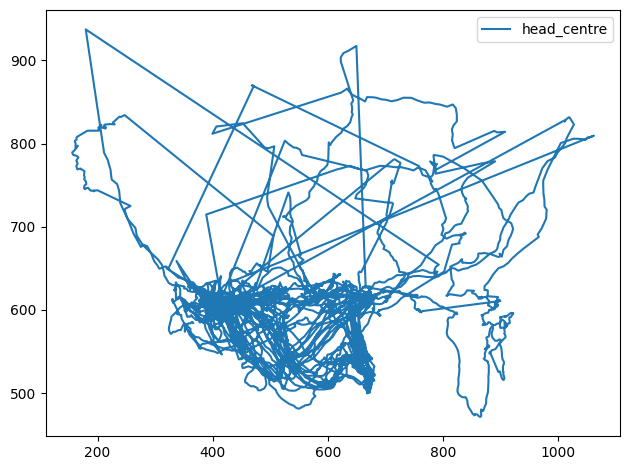

In [12]:
start = None
end = 10000
likelihood_threshold = 0.98

keypoint_data = back_pos_df.loc[:, (slice(None), "head_centre", ["x", "y", "likelihood"])]
keypoint_data = filter_df_on_likelihood(keypoint_data, likelihood_threshold)
plt.plot(keypoint_data.x[start:end], keypoint_data.y[start:end], label="head_centre")
plt.legend()
plt.tight_layout()

In [13]:
back_ports_df = pd.read_hdf(os.path.join(folder, "video", "tracking", "2_task", "back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5"), "df_with_missing")
back_ports_df

scorer    DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000              \
bodyparts                                                   port2               
coords                                                          x           y   
0                                                 539.760559       632.626099   
1                                                 539.825745       632.553162   
2                                                 540.229858       632.301697   
3                                                 540.206665       632.321167   
4                                                 540.216003       632.320312   
...                                                      ...              ...   
164722                                            539.439392       630.837463   
164723                                            539.423096       630.836975   
164724                                            539.477478       630.818542   
164725                                            539.448669       630.819702   
164726                                            539.438721       630.775330   

scorer                                                               \
bodyparts                  port1                              port6   
coords    likelihood           x           y likelihood           x   
0           0.211554  538.751221  630.036011   0.970708  540.977051   
1           0.366904  538.636902  629.978943   0.942097  541.005615   
2           0.482847  538.679810  629.849976   0.912612  540.971008   
3           0.438246  538.718201  629.988586   0.920505  541.000366   
4           0.535277  538.661682  629.881653   0.889066  541.014099   
...              ...         ...         ...        ...         ...   
164722      0.998269  407.488617  628.166199   0.999983  534.502380   
164723      0.998220  407.458984  628.165649   0.999983  534.037354   
164724      0.998497  407.475922  628.160034   0.999981  535.817627   
164725      0.998540  407.430084  628.199158   0.999982  538.270020   
164726      0.998666  407.497437  628.210327   0.999982  539.001038   

scorer                                                               \
bodyparts                              port3                          
coords              y likelihood           x           y likelihood   
0          505.734894   0.999827  676.380493  631.940613   0.999951   
1          505.765503   0.999863  676.362122  631.970947   0.999957   
2          505.684296   0.999870  676.423889  631.904724   0.999958   
3          505.680298   0.999873  676.451416  631.921448   0.999959   
4          505.676971   0.999881  676.511658  631.835022   0.999959   
...               ...        ...         ...         ...        ...   
164722     509.325989   0.145076  676.588928  636.191956   0.999567   
164723     512.403137   0.288575  676.673462  635.947693   0.999655   
164724     511.911926   0.953766  676.931152  635.673279   0.999811   
164725     512.051575   0.999509  677.153076  634.733093   0.999836   
164726     511.601501   0.999840  677.775024  633.866821   0.999846   

scorer                                        
bodyparts       port7                         
coords              x           y likelihood  
0          679.409729  506.589691   0.999850  
1          679.371094  506.440277   0.999857  
2          679.413330  506.569702   0.999857  
3          679.378479  506.626038   0.999858  
4          679.356323  506.615875   0.999870  
...               ...         ...        ...  
164722     678.733398  507.431793   0.999968  
164723     678.796509  507.476868   0.999969  
164724     678.736816  507.576233   0.999972  
164725     678.618835  507.562042   0.999971  
164726     678.653625  507.614349   0.999972  

[164727 rows x 15 columns]

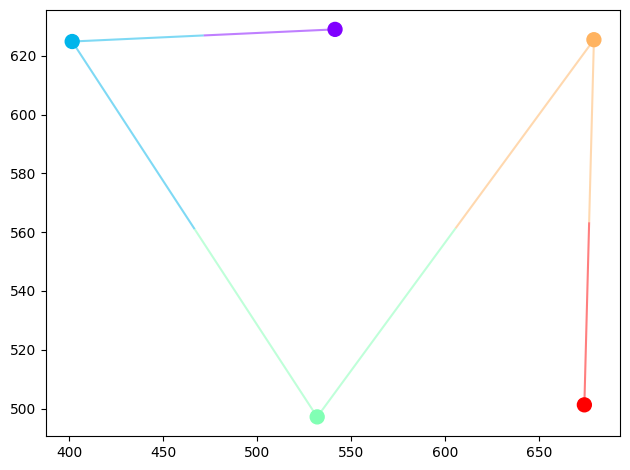

In [14]:
start = None
end = None
likelihood_threshold = 0.9999
bins = 20

fig, ax = plt.subplots()

port_names = back_ports_df.columns.get_level_values(1).unique()
port_points = np.zeros((2, len(port_names)))

for i, port_name in enumerate(port_names):
    port_data = back_ports_df.loc[:, (slice(None), port_name, ["x", "y", "likelihood"])]
    port_data = filter_df_on_likelihood(port_data, likelihood_threshold)
    port_point = extract_centre_point_using_histogram(port_data, bins)
    port_points[:,i] = port_point
    # plt.imshow(port_hist_counts)
    # plt.show()

# ax.plot(port_points[0], port_points[1], c="black")
ax.scatter(port_points[0], port_points[1], c=np.arange(port_points.shape[1]), cmap="rainbow", s=100)
lines = colored_line(port_points[0], port_points[1], np.arange(port_points.shape[1]), ax, cmap="rainbow", alpha=0.5)
plt.tight_layout()


In [15]:
behavioral_data_filename = "/ceph/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30-03-2022/behav_sync/2_task/Behav_Ephys_Camera_Sync.csv"

behavioral_data = pd.read_csv(behavioral_data_filename, index_col=0)
behavioral_data

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,TrainingLevel,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
0,1,33.5779,7,39.1177,39.3896,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,347.811700,20520.0,342.000000,347.539800,347.811700,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
1,1,33.5779,7,39.5222,39.7818,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,348.203900,20520.0,342.000000,347.944300,348.203900,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2,1,33.5779,7,45.3722,45.9151,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,354.337200,20520.0,342.000000,353.794300,354.337200,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
3,1,33.5779,1,46.7517,47.4965,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,355.918600,20520.0,342.000000,355.173800,355.918600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
4,1,33.5779,3,49.2089,49.3717,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,357.793800,20520.0,342.000000,357.631000,357.793800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2177,277,2411.2686,6,2414.8285,2415.0117,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2724.709767,163258.0,2720.966667,2724.526567,2724.709767,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2178,277,2411.2686,3,2415.3505,2415.7008,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.398867,163258.0,2720.966667,2725.048567,2725.398867,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2179,277,2411.2686,2,2415.3840,2415.5804,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.278467,163258.0,2720.966667,2725.082067,2725.278467,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2180,277,2411.2686,2,2415.5868,2415.6890,NaN,2416.4933,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2725.387067,163258.0,2720.966667,2725.284867,2725.387067,163258.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [16]:
behavioral_data.columns

Index(['Trial_id', 'Trial_Start', 'Port', 'PokeIn_Time', 'PokeOut_Time',
       'Reward_Times', 'Trial_End', 'Port_2-3-4-5_LED_intensities',
       'Port_1-2-3-4_RewardAmount', 'TrainingLevel', 'TrialStart_EphysTime',
       'FirstPoke_EphysTime', 'PokeIN_EphysTime', 'PokeOUT_EphysTime',
       'backcam_trialstart_seconds', 'backcam_aligned_pokein_times',
       'backcam_aligned_pokeout_times', 'backcam_trialstart_timestamps',
       'sidecam_trialstart_seconds', 'sidecam_aligned_pokein_times',
       'sidecam_aligned_pokeout_times', 'sidecam_trialstart_timestamps',
       'bottomcam_trialstart_seconds', 'bottomcam_aligned_pokein_times',
       'bottomcam_aligned_pokeout_times', 'bottomcam_trialstart_timestamps'],
      dtype='object')

In [17]:
valid_seqs_indices = findIndicesOfValidSeqs(behavioral_data)
correct_seqs = behavioral_data.iloc[valid_seqs_indices]
correct_seqs

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,Port_2-3-4-5_LED_intensities,Port_1-2-3-4_RewardAmount,TrainingLevel,...,backcam_aligned_pokeout_times,backcam_trialstart_timestamps,sidecam_trialstart_seconds,sidecam_aligned_pokein_times,sidecam_aligned_pokeout_times,sidecam_trialstart_timestamps,bottomcam_trialstart_seconds,bottomcam_aligned_pokein_times,bottomcam_aligned_pokeout_times,bottomcam_trialstart_timestamps
17,1,33.5779,2,61.4296,61.8883,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,370.310400,20520.0,342.000000,369.851700,370.310400,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
18,1,33.5779,1,63.1067,63.4154,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,371.837500,20520.0,342.000000,371.528800,371.837500,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
19,1,33.5779,6,64.3364,64.5665,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,372.988600,20520.0,342.000000,372.758500,372.988600,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
20,1,33.5779,3,64.9775,65.1747,NaN,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,373.596800,20520.0,342.000000,373.399600,373.596800,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
21,1,33.5779,7,65.5319,66.7492,65.5319,67.5441,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,375.171300,20520.0,342.000000,373.954000,375.171300,20520.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2170,276,2406.9343,1,2408.3064,2408.4858,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2718.184833,162998.0,2716.633333,2718.005433,2718.184833,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2171,276,2406.9343,6,2409.0497,2409.2679,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2718.966933,162998.0,2716.633333,2718.748733,2718.966933,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2172,276,2406.9343,3,2409.6475,2409.8396,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2719.538633,162998.0,2716.633333,2719.346533,2719.538633,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data
2173,276,2406.9343,3,2410.0185,2410.4540,NaN,2411.2683,"[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]",50,...,2720.153033,162998.0,2716.633333,2719.717533,2720.153033,162998.0,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data,Cameras Corrupted no video data


In [18]:
first_poke_correct_seq = correct_seqs[correct_seqs["Port"] == 2].reset_index().groupby("Trial_id").agg("first")
first_poke_correct_seq[["index", "backcam_aligned_pokein_times", "backcam_aligned_pokeout_times"]]

,index,backcam_aligned_pokein_times,backcam_aligned_pokeout_times
Trial_id,,,
1,17,369.851700,370.310400
2,23,379.374733,379.378333
3,33,389.824867,389.827067
4,41,394.764100,394.775700
5,48,400.249367,400.260267
...,...,...,...
268,2092,2235.348733,2235.453433
269,2099,2243.105000,2243.162400
274,2147,2681.461633,2681.531333


In [19]:
last_poke_correct_seq = correct_seqs[correct_seqs["Port"] == 7].reset_index().groupby("Trial_id").agg("first")
last_poke_correct_seq[["index", "backcam_aligned_pokein_times", "backcam_aligned_pokeout_times"]]

,index,backcam_aligned_pokein_times,backcam_aligned_pokeout_times
Trial_id,,,
1,21,373.954000,375.171300
2,29,382.147133,383.550333
3,40,392.219267,393.723567
4,47,397.511400,399.471700
5,54,403.279167,405.688267
...,...,...,...
268,2096,2237.148333,2239.931633
269,2104,2245.240500,2245.772400
274,2153,2684.801233,2696.459633


In [20]:
starts_ends_times_seqs = get_starts_ends_of_sequence(first_poke_correct_seq, last_poke_correct_seq, start_time_col="backcam_trialstart_seconds")
starts_ends_times_seqs

,start_time,end_time
Trial_id,,
1,342.000000,375.171300
2,375.983333,383.550333
3,382.566667,393.723567
4,392.650000,399.471700
5,397.916667,405.688267
...,...,...
268,2233.083333,2239.931633
269,2237.550000,2245.772400
274,2661.383333,2696.459633


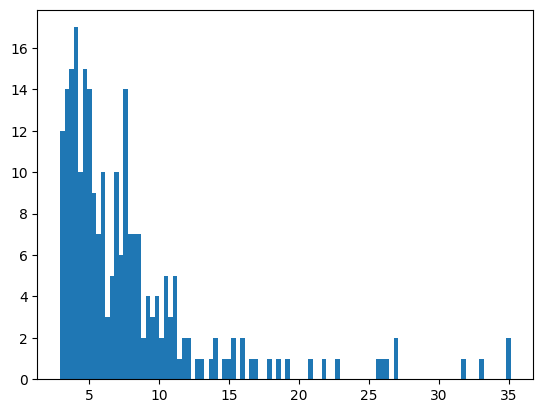

In [21]:
plt.hist(starts_ends_times_seqs.end_time - starts_ends_times_seqs.start_time, bins=100)
plt.show()

In [22]:
fps = 60
tracking_idxs_df = get_dlc_idxs_from_times_df_using_raw_timestamps(starts_ends_times_seqs, raw_timestamps, fps)
tracking_idxs_df

,start_idx,end_idx
0,20520,22510
1,22559,23013
2,22954,23623
3,23559,23968
4,23875,24341
...,...,...
238,133984,134395
239,134252,134746
240,159682,161787
241,161113,163019


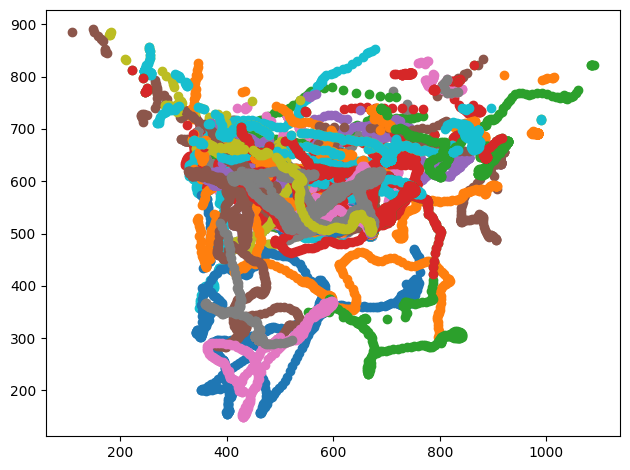

In [23]:
trial_time_threshold = np.Inf
for i in range(len(tracking_idxs_df)):
    if starts_ends_times_seqs.iloc[i].end_time - starts_ends_times_seqs.iloc[i].start_time <= trial_time_threshold:
        start_idx, end_idx = tracking_idxs_df.iloc[i].values
        plt.scatter(keypoint_data.x[start_idx:end_idx], keypoint_data.y[start_idx:end_idx], label="head_centre")
# plt.legend()
plt.tight_layout()
plt.show()

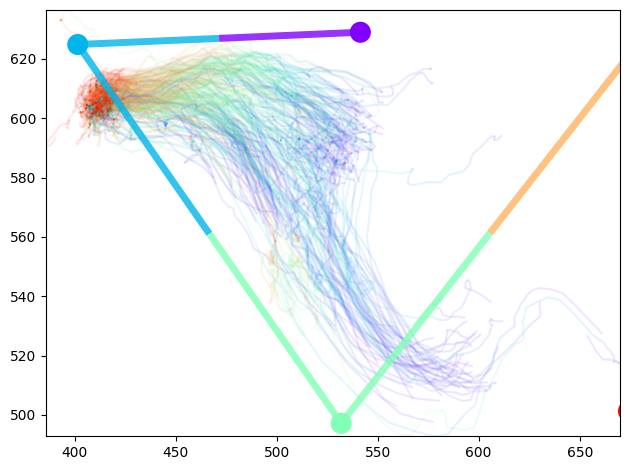

In [55]:
all_trajectories = []
trial_time_threshold = np.inf
t = np.linspace(0, 1, 1000)
for i in range(len(tracking_idxs_df)):
    if starts_ends_times_seqs.iloc[i].end_time - starts_ends_times_seqs.iloc[i].start_time <= trial_time_threshold:
        start_idx, end_idx = tracking_idxs_df.iloc[i].values
        keypoint_data_x = keypoint_data.loc[start_idx:end_idx].x
        keypoint_data_y = keypoint_data.loc[start_idx:end_idx].y
        xp = np.linspace(0, 1, len(keypoint_data_x))
        keypoint_data_x_interp = np.interp(t, xp, keypoint_data_x)
        keypoint_data_y_interp = np.interp(t, xp, keypoint_data_y)
        all_trajectories.append(np.vstack([keypoint_data_x_interp, keypoint_data_y_interp]))

all_trajectories = np.array(all_trajectories)
fig, ax = plt.subplots()

for trial in all_trajectories:
    x = trial[0]
    y = trial[1]
    lines = colored_line(x, y, t, ax, cmap="rainbow", alpha=0.1)

lines = colored_line(port_points[0], port_points[1], np.arange(port_points.shape[1]), ax, linewidth=5, cmap="rainbow", alpha=0.8)
ax.scatter(port_points[0], port_points[1], label=port_name, c=np.arange(port_points.shape[1]), cmap="rainbow", s=200, zorder=3)

ax.set_xlim([np.min(all_trajectories[:,0]), np.max(all_trajectories[:,0])])
ax.set_ylim([np.min(all_trajectories[:,1]), np.max(all_trajectories[:,1])])
plt.tight_layout()
plt.show()

In [107]:
correct_seqs[correct_seqs["Trial_id"] == 55][["Trial_id", "Port", "backcam_aligned_pokein_times", "backcam_aligned_pokeout_times"]]

,Trial_id,Port,backcam_aligned_pokein_times,backcam_aligned_pokeout_times
442,55,2,740.601267,740.605167
443,55,2,740.610867,740.616767
444,55,2,740.617267,740.780567
445,55,2,740.796767,740.882767
446,55,2,740.926667,741.226767
447,55,1,741.118567,741.268267
448,55,6,741.652167,741.768567
449,55,3,742.096167,742.214567
450,55,7,742.516967,745.133067


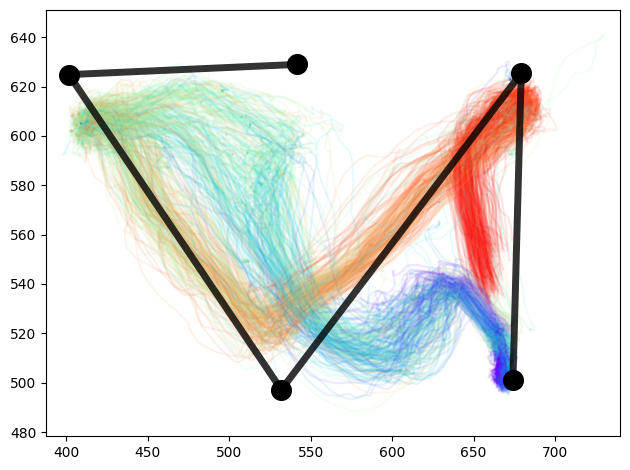

In [106]:
all_trajectories = []
trial_time_threshold = 10
t = np.linspace(0, 1, 1000)
likelihood_threshold = 0.999

poke1_correct_seq = correct_seqs[correct_seqs["Port"] == 2].groupby("Trial_id").agg("last")
poke2_correct_seq = correct_seqs[correct_seqs["Port"] == 7].groupby("Trial_id").agg("last")
starts_ends_times_seqs = get_starts_ends_of_sequence(poke1_correct_seq, 
                                                     poke2_correct_seq,
                                                     start_time_col="backcam_trialstart_seconds",
                                                     end_time_col="backcam_aligned_pokein_times")
tracking_idxs_df = get_dlc_idxs_from_times_df_using_raw_timestamps(starts_ends_times_seqs, raw_timestamps, fps)

keypoint_data = back_pos_df.loc[:, (slice(None), "head_centre", ["x", "y", "likelihood"])]
keypoint_data = filter_df_on_likelihood(keypoint_data, likelihood_threshold)

for i in range(len(tracking_idxs_df)):
    duration = starts_ends_times_seqs.iloc[i].end_time - starts_ends_times_seqs.iloc[i].start_time
    if duration < 0:
        trial_id = poke1_correct_seq.iloc[i].name
        print(f"Duration: {duration} is invalid. Check start time and end time on trial: {trial_id}.")
        continue
    if duration <= trial_time_threshold:
        start_idx, end_idx = tracking_idxs_df.iloc[i].values
        trajectory = keypoint_data.loc[start_idx:end_idx]
        x_interp, y_interp = interpolate_x_y_data(trajectory, t)
        all_trajectories.append(np.vstack([x_interp, y_interp]))

all_trajectories = np.array(all_trajectories)
fig, ax = plt.subplots()

for trial in all_trajectories:
    x = trial[0]
    y = trial[1]
    lines = colored_line(x, y, t, ax, cmap="rainbow", alpha=0.1)

# mean_trajectories = np.mean(all_trajectories, axis=0).T
# ax.plot(mean_trajectories[:,0], mean_trajectories[:,1], c="black")
# lines = colored_line(port_points[0], port_points[1], np.arange(port_points.shape[1]), ax, linewidth=5, cmap="rainbow", alpha=0.8)
# ax.scatter(port_points[0], port_points[1], label=port_name, c=np.arange(port_points.shape[1]), cmap="rainbow", s=200, zorder=3)
ax.plot(port_points[0], port_points[1], linewidth=5, c="black", alpha=0.8)
ax.scatter(port_points[0], port_points[1], c="black", s=200, zorder=3)

padding = 10

min_x = np.min([np.min(all_trajectories[:,0]), np.min(port_points[0])])
max_x = np.max([np.max(all_trajectories[:,0]), np.max(port_points[0])])
ax.set_xlim([min_x - padding, max_x + padding])

min_y = np.min([np.min(all_trajectories[:,1]), np.min(port_points[1])])
max_y = np.max([np.max(all_trajectories[:,1]), np.max(port_points[1])])
ax.set_ylim([min_y - padding, max_y + padding])

plt.tight_layout()
plt.show()

set paths:

In [2]:
## set paths!

mouse_implant_recording = '178_1_7'


OE_processor_path = r"/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/Record Node 103/experiment1/recording1/continuous"
OE_raw_path = r"/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/"

# this is the path to a histology file, this is needed in order to know the exact depth/location of each electrode
hist_path = r"/ceph/sjones/projects/sequence_squad/data/histology/Neuropixel_tracks/EJT178/brainreg/manual_segmentation/standard_space/tracks/"
hist_file = 'implant1'


##### check date at bottom lines up:
PATH = r"/ceph/sjones/projects/sequence_squad/organised_data/animals"

for file_ in os.listdir(PATH):
    if 'EJT' in file_.split('_')[0]:
        mouse_number = int(re.findall(r'\d+', file_.split('_')[0])[0])
        implant_number = int(re.findall(r'\d+', file_.split('_')[-1])[0])
        if mouse_implant_recording.split('_')[0] == str(mouse_number):
            if mouse_implant_recording.split('_')[1] == str(implant_number):
                mouse_name = file_.split('_')[0]
                implant_num = implant_number
                PATH = os.path.join(PATH,file_)
                break
for file_ in os.listdir(PATH):
    if 'recording' in file_.split('_')[0]:
        if mouse_implant_recording.split('_')[-1] == str(re.findall(r'\d+', file_.split('_')[0])[0]):
            date_file = file_
            org_data_path = os.path.join(PATH,date_file)
            break
            
print('---------------------------------------------------')
print('DATES should line up:')
print(org_data_path)
print(OE_raw_path)
print(OE_processor_path)
print('---------------------------------------------------')

---------------------------------------------------
DATES should line up:
/ceph/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30-03-2022
/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/
/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/Record Node 103/experiment1/recording1/continuous
---------------------------------------------------


set processor variables to use

In [3]:
#sample rate:
Fs = 2500

## import NP track position:
import pandas as pd

probe_track_file = hist_path + hist_file + '.csv'

implant_df = pd.read_csv(probe_track_file)

import re
count = 0
for processor in os.listdir(OE_processor_path):
    if count == 0:
        main1 = int(re.findall(r'\d+', processor)[0])
        main1_2 = processor.split('.')[-1]
    elif count == 1:
        main2 = int(re.findall(r'\d+', processor)[0])
        main2_2 = processor.split('.')[-1]
    elif count == 2:
        main3 = int(re.findall(r'\d+', processor)[0])
        main3_2 = processor.split('.')[-1]
    count +=1 

main_processor_tuple=(main1, main1_2)

aux_processor_tuples=((main2,main2_2),(main3,main3_2))


load in OE data and align across processors (global alignment) 

In [4]:

### LOAD in data: this could take a few minutes
recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,OE_raw_path)
recording.compute_global_timestamps()


this should be zero:
0
Processor ID: 102, Stream Name: 0, Line: 1 (main sync line))
  First event sample number: 60920380
  Last event sample number: 512017786
  Total sync events: 15036
  Sample rate: 30000
Processor ID: 109, Stream Name: 1, Line: 1 (aux sync line))
  First event sample number: 5075153
  Last event sample number: 42662882
  Total sync events: 15036
  Scale factor: 12.001188100510143
  Actual sample rate: 2499.7525035646067
Processor ID: 109, Stream Name: 0, Line: 1 (aux sync line))
  First event sample number: 60901832
  Last event sample number: 511954579
  Total sync events: 15036
  Scale factor: 1.0000990105931002
  Actual sample rate: 29997.029976270802


align to depth information and to offset

In [5]:
data = recording.continuous[1].samples

if int(mouse_implant_recording.split('_')[0]) > 250:
    timestamps = recording.continuous[1].timestamps
else:
    timestamps = np.load(OE_processor_path + '/' + 'Neuropix-PXI-' + str(aux_processor_tuples[0][0]) + '.' + str(aux_processor_tuples[0][1]) + '/' + 'synchronized_timestamps.npy')

## chose 6 channels: #
channels = [50,100,150,200,250,300,350]

### add in region info based on depth:
try:
    callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccb')))
except:
    callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccg')))

proportion_in_motor_cortex = (callosum_middle_index/len(implant_df))
# there should be 400 channels per 4000um 
# tot_channels = 384
# bank_spacing = 20 # 20um
# channels_per_bank = 2
first_cortex_channel = int(proportion_in_motor_cortex * 400)

# save out data:
timestamps_s = timestamps/2500
timestamps_s_offset_adjusted = timestamps_s - timestamps_s[0]

channel_regions = []
for channel in channels:
    if channel > first_cortex_channel:
        channel_regions.append('m_crtex')
    elif channel < first_cortex_channel:
        channel_regions.append('striatum')

# save timestamp data
save_file_path = org_data_path + r"/ephys/LFP/"
if not os.path.isdir(save_file_path):
    os.makedirs(save_file_path)
    
np.save(save_file_path+ 'LFP_timestamps.npy',timestamps_s)
np.save(save_file_path+ 'aligned_LFP_timestamps.npy',timestamps_s_offset_adjusted)

## free up memory
del timestamps_s
del timestamps_s_offset_adjusted


loop over each chosen channel and save out data

In [6]:
### add in region info based on depth:
for chosen_channel in channels:
    data_channel = []
    chunk_size = 2000 # adjust this value to balance speed and memory usage
    for i in tqdm(range(0, len(data), chunk_size)):
        chunk = [data[j][chosen_channel] for j in range(i, min(i+chunk_size, len(data)))]
        data_channel += chunk
        
    if chosen_channel > first_cortex_channel:
        data_region = 'm-crtx'
    elif chosen_channel < first_cortex_channel:
        data_region = 'striatum'
        
    save_path = save_file_path + 'channel-' + str(chosen_channel) + '_REGION-' + data_region + "_LFP_data.npy"
    
    np.save(save_path,data_channel)
    print('data saved for channel ' + str(chosen_channel))
    # clean up for memory
    del data_channel
    
print('done')       

 13%|█▎        | 2462/18796 [00:14<01:33, 175.14it/s]


KeyboardInterrupt: 